<a href="https://colab.research.google.com/github/alasarerhan/Deep-Learning-Projects/blob/main/end_to_end_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning with MobileNetv2 BackBone

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
import tensorflow as tf

In [ ]:
import os, random, datetime
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_input_mobilenetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD

## Functions

In [ ]:
def get_image_paths(root_dir, num_images=None):
  all_images = []
  for extension in ['*.jpg', '*.jpeg', '*.png']:
    all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
  if num_images is None:
    return all_images
  else:
    return random.sample(all_images, min(num_images, len(all_images)))

def display_images(img_list):
  plt.figure(figsize=(15,6))
  for i, img_path in enumerate(img_list):
    img = image.load_img(img_path)
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2,5, i+1)
    plt.imshow(img.squeeze())
    plt.axis('off')
  plt.show()


def print_predicted_class(predicted_class):
  for full_path, (label, probability) in predicted_classes.items():
    filename = os.path.basename(full_path)
    print(f"{filename}: {label} ({probability:.2f}%)")


def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

  # Loss
  plt.figure(figsize=(10,5))
  plt.plot(history.history[train_loss], label='Training Loss')
  plt.plot(history.history[val_loss], label='Validation Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Metrics
  plt.figure(figsize=(10,5))
  plt.plot(history.history[train_metric], label=f"Training:{train_metric}")
  plt.plot(history.history[val_metric], label=f"Validation:{val_metric}")
  plt.title(f'Training and Validation {train_metric} Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel(f'train_metric')
  plt.legend()
  plt.show()

# Data Preparation & Augmentation

In [ ]:
dir_path = "/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification"

In [ ]:
img_list = get_image_paths(dir_path)
len(img_list)

2527

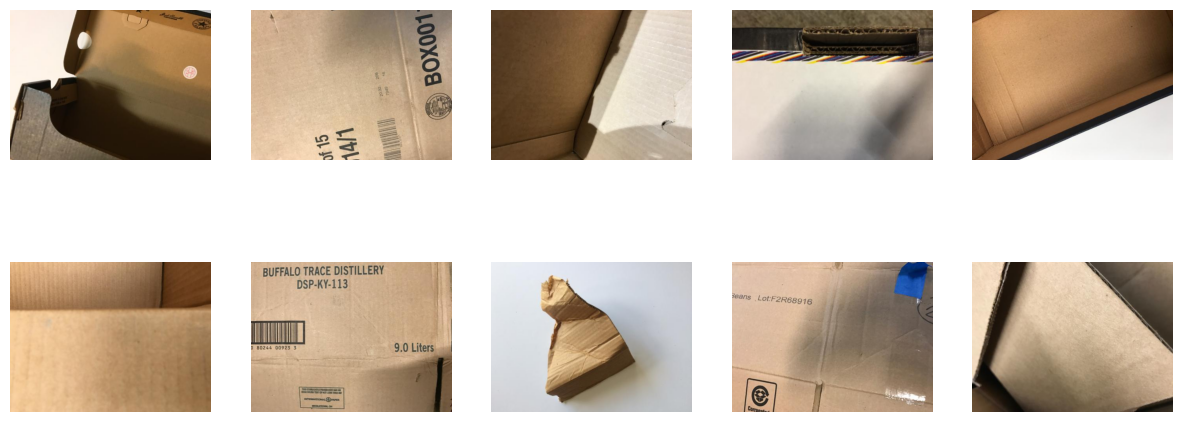

In [ ]:
display_images(img_list[0:10])

In [ ]:
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split = 0.1,
                           rescale = 1./255,
                           shear_range = 0.1,
                           zoom_range = 0.1,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1,)

val = ImageDataGenerator(rescale = 1./255,
                          validation_split = 0.1)

In [ ]:
train_generator = train.flow_from_directory(dir_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset = 'training')

validation_generator = val.flow_from_directory(dir_path,
                                              target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              subset = 'validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# Frozen Layers

## MobileNetV2 Backbone

In [ ]:
mobilenet_backbone = MobileNetV2(weights = 'imagenet',
                                 include_top =False,   #modelin en üst katmanı çalışmaya dahil edilsin mi edilmesin mi? -> tam bağlantılı katmanlar gelsin.
                                 input_shape = (224, 224, 3))

# alpha parametresi -> varsayılan 1 -> tanımlanan filtre sayısının % kaçının kullanılacağını ifade eder.
# include_top = True yapılırsa çıktı katmanı bilgisini güncellememiz gerekir. Bu durumda class sayısını belirtmemiz gerekir

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
mobilenet_backbone.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Assume that i want to know the number of layers in MobileNetV2 backbone
print(f"Total numebr of layers in MobileNetV2: {len(mobilenet_backbone.layers)}")

Total numebr of layers in MobileNetV2: 154


In [ ]:
# Counting blocks

block_count = 0
for layer in mobilenet_backbone.layers:
  if isinstance(layer, tf.keras.layers.Conv2D) and 'expand' in layer.name:
    block_count += 1
print(f"Total number of logical blocks in MobileNetV2: {block_count}")

Total number of logical blocks in MobileNetV2: 17


In [ ]:
# Examining the layers for trainability

for layer in mobilenet_backbone.layers:
  print(layer.name, layer.trainable)

input_layer True
Conv1 True
bn_Conv1 True
Conv1_relu True
expanded_conv_depthwise True
expanded_conv_depthwise_BN True
expanded_conv_depthwise_relu True
expanded_conv_project True
expanded_conv_project_BN True
block_1_expand True
block_1_expand_BN True
block_1_expand_relu True
block_1_pad True
block_1_depthwise True
block_1_depthwise_BN True
block_1_depthwise_relu True
block_1_project True
block_1_project_BN True
block_2_expand True
block_2_expand_BN True
block_2_expand_relu True
block_2_depthwise True
block_2_depthwise_BN True
block_2_depthwise_relu True
block_2_project True
block_2_project_BN True
block_2_add True
block_3_expand True
block_3_expand_BN True
block_3_expand_relu True
block_3_pad True
block_3_depthwise True
block_3_depthwise_BN True
block_3_depthwise_relu True
block_3_project True
block_3_project_BN True
block_4_expand True
block_4_expand_BN True
block_4_expand_relu True
block_4_depthwise True
block_4_depthwise_BN True
block_4_depthwise_relu True
block_4_project True
blo

In [ ]:
for layer in mobilenet_backbone.layers[-11:]:
  print(layer.name, layer.trainable)

block_16_expand True
block_16_expand_BN True
block_16_expand_relu True
block_16_depthwise True
block_16_depthwise_BN True
block_16_depthwise_relu True
block_16_project True
block_16_project_BN True
Conv_1 True
Conv_1_bn True
out_relu True


In [ ]:
# To train only the last layers we want we need to change other layers to untrainable

for layer in mobilenet_backbone.layers:
  layer.trainable = False

In [ ]:
# Examining the layers for trainability again

for layer in mobilenet_backbone.layers:
  print(layer.name, layer.trainable)

input_layer False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_dep

In [ ]:
# Making layers we want trainable:
for layer in mobilenet_backbone.layers[-11:]:
  layer.trainable = True

In [ ]:
for layer in mobilenet_backbone.layers:
  print(layer.name, layer.trainable)

input_layer False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_dep

# Training

In [ ]:
# Outputu boyut indirgeyerek başlamalıyız.
x = GlobalAveragePooling2D()(mobilenet_backbone.output)

In [ ]:
# 6 sınıflı bir veri setimiz var bu nedenle çıktı katmanı olarak sınıf sayısı kadar nörona sahip bir katman eklemeliyiz.
x = Dense(6 , activation = 'softmax')(x)

In [ ]:
fine_tuning_model = Model(inputs = mobilenet_backbone.input, outputs = x)

In [ ]:
metrics = ['accuracy', AUC(name='auc', multi_label =True)]

In [ ]:
optimizer = SGD(learning_rate = 0.0001, momentum = 0.9, nesterov = True)
# nesterov ivmesi: gradyanın yön değiştirdiği durumlarda algorithamanın daha hızlı ve akıllı bir şekilde tepki vermesini sağlar.
# modelin original yapısına mümkün olan en az şekilde dokunabilmek adına başlangıçta learning rate'i olabildiğince düşük tutuyor,
# geçmiş momnetumu takip edip ağırlıkları sapıttırmamaka adına momentumu yüksek tutuyoruz.

In [ ]:
fine_tuning_model.compile(optimizer = optimizer,
                          loss = 'categorical_crossentropy',
                          metrics = metrics)

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 10,
                               restore_best_weights = True,
                               verbose = 1),

model_checkpoint = ModelCheckpoint('mobilenetv2_finetuned.keras',
                                   monitor = 'val_loss',
                                   save_best_only = True,
                                   save_weights_only = False,
                                   verbose = 1)

In [ ]:
start_time = datetime.datetime.now()

fine_tuning_model_history = fine_tuning_model.fit(
    train_generator,
    epochs = 100,
    validation_data = validation_generator,
    callbacks = [early_stopping, model_checkpoint]
)

end_time = datetime.datetime.now()
print(f"Training time: {end_time - start_time}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/72 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step - accuracy: 0.2110 - auc: 0.5629 - loss: 1.9759 
Epoch 1: val_loss improved from inf to 1.48374, saving model to mobilenetv2_finetuned.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1011s 13s/step - accuracy: 0.2170 - auc: 0.5681 - loss: 1.9616 - val_accuracy: 0.4183 - val_auc: 0.7565 - val_loss: 1.4837
Epoch 2/100
69/72 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - accuracy: 0.5569 - auc: 0.8189 - loss: 1.2275
Epoch 2: val_loss improved from 1.48374 to 1.24987, saving model to mobilenetv2_finetuned.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.5589 - auc: 0.8204 - loss: 1.2228 - val_accuracy: 0.5020 - val_auc: 0.8451 - val_loss: 1.2499
Epoch 3/100
69/72 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - accuracy: 0.6480 - auc: 0.8956 - loss: 0.9760
Epoch 3: val_loss improved from 1.24987 to 1.10875, saving model to mobilenetv2_finetuned.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.6488 - auc: 0.8959 - loss: 0.9743 - val_accuracy: 0.5618 - val_auc: 0

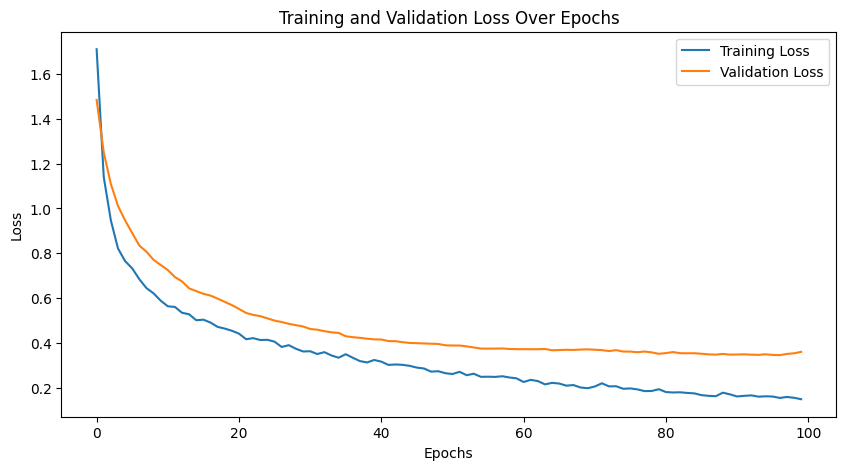

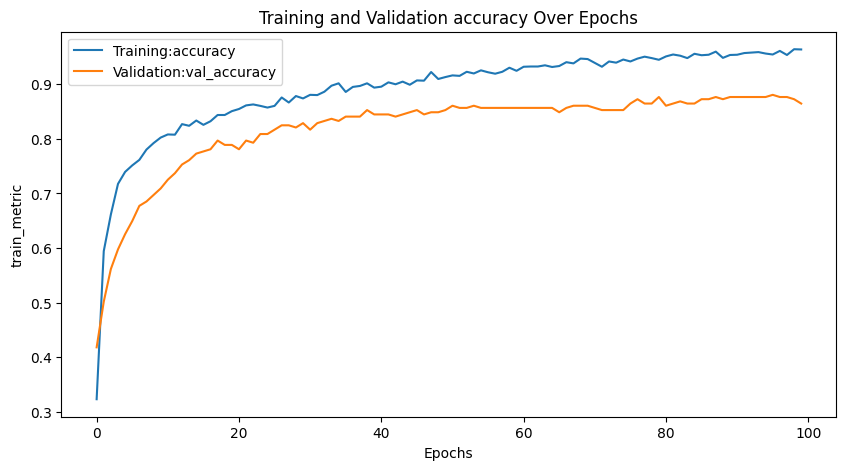

In [ ]:
plot_training_history(fine_tuning_model_history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

In [ ]:
val_loss, val_accuracy, val_auc = fine_tuning_model.evaluate(validation_generator, verbose = 0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

Validation Loss: 0.3455
Validation Accuracy: 0.8765
Validation AUC: 0.9863


# Prediction && Inference

### Eğitilmiş olan modeller ile çıkarımda bulunmak

In [ ]:
waste_labels = {0 : 'cardboard', 1: 'glass', 2:'metal', 3:'paper', 4:'plastic', 5:'trash'}

In [ ]:
dir_path = "/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification"

In [ ]:
img_list = get_image_paths(dir_path, 10)

In [ ]:
garbage_tuned_model = load_model("/content/mobilenetv2_finetuned.keras")

In [ ]:
def preprocess_mobilenet(img_path):
  img = image.load_img(img_path, target_size = (224,224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input_mobilenetV2(img_array)
  return img_array

def predict_mobilenet(model, img_array, class_labels):
  predictions = model.predict(img_array)
  predicted_class_idx = np.argmax(predictions[0])
  predicted_class = class_labels[predicted_class_idx]
  probability = np.max(predictions[0])
  return predicted_class, probability


def visualize_preds_mobilenet(model, image_paths, class_labels, visualize=False):
  results = {}

  for img_path in image_paths:
    img_array = preprocess_mobilenet(img_path)
    label, probability = predict_mobilenet(model, img_array, class_labels)
    results[img_path] = (label, probability)
    if visualize:
      plt.figure(figsize = (5,5))
      plt.imshow(image.load_img(img_path))
      plt.title(f"Predicted: {label} ({probability:.2f}%)")
      plt.axis('off')
      plt.show()
  return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


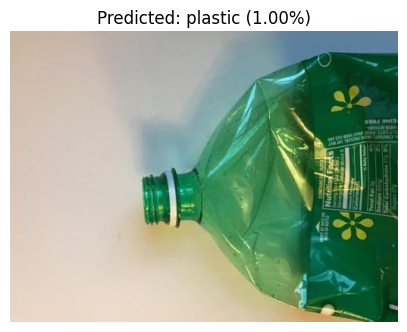

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


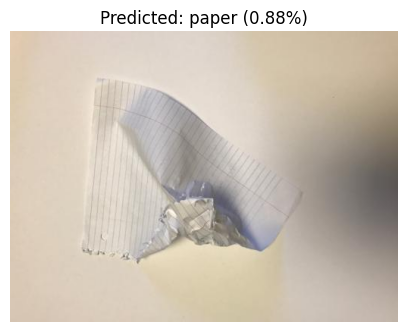

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


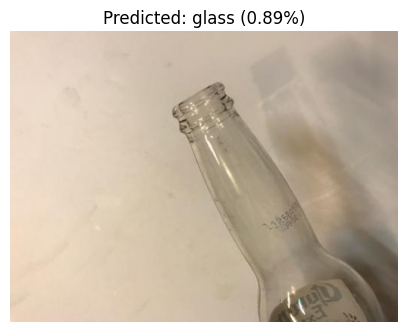

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


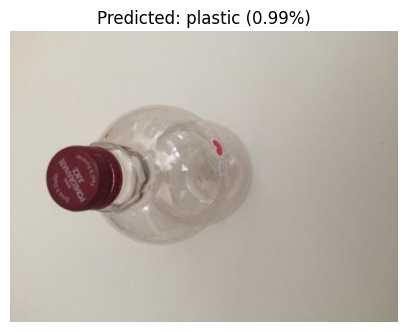

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


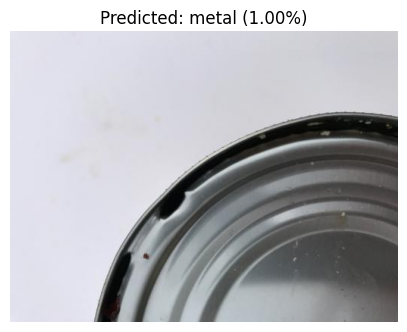

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


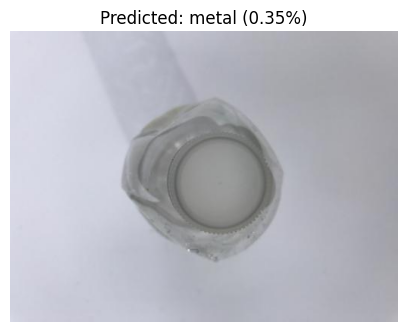

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


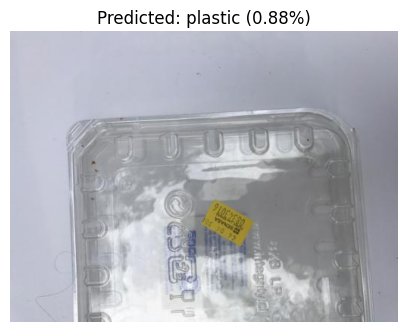

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


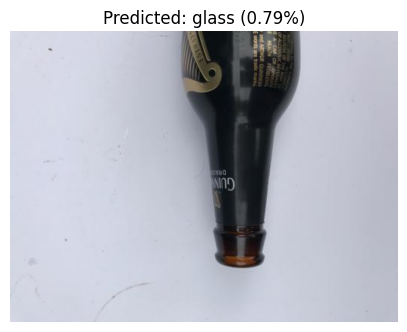

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


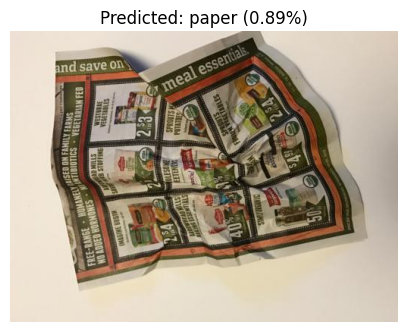

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


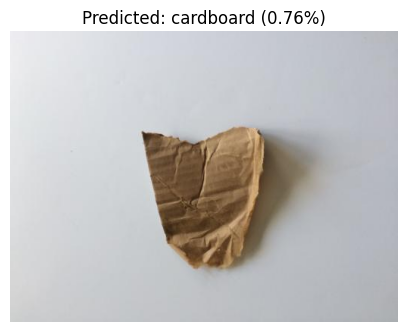

In [ ]:
predicted_classes = visualize_preds_mobilenet(garbage_tuned_model, img_list, class_labels=waste_labels,visualize=True)

In [ ]:
def print_predicted_classes(predicted_class):
  for full_path, (label, probability) in predicted_classes.items():
    filename = os.path.basename(full_path)
    print(f"{filename}: {label} ({probability:.2f}%)")

In [ ]:
print_predicted_classes(predicted_classes)

plastic391.jpg: plastic (1.00%)
paper170.jpg: paper (0.88%)
glass393.jpg: glass (0.89%)
plastic7.jpg: plastic (0.99%)
metal135.jpg: metal (1.00%)
plastic52.jpg: metal (0.35%)
plastic321.jpg: plastic (0.88%)
glass472.jpg: glass (0.79%)
paper248.jpg: paper (0.89%)
cardboard152.jpg: cardboard (0.76%)


# Full Network Fine Tuning

In [ ]:
dir_path = "/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification"

In [ ]:
img_list = get_image_paths(dir_path)
len(img_list)

2527

In [ ]:
garbage_tuned_model = load_model("/content/mobilenetv2_finetuned.keras")